In [1]:
import pandas as pd
import numpy as np


df_x = pd.read_csv('DataBase\XAUT_MEXC1m.csv', parse_dates=['timestamp'], index_col='timestamp')
df_p = pd.read_csv('DataBase\PAXG_MEXC1m.csv', parse_dates=['timestamp'], index_col='timestamp')

# 重命名收盘价列，避免同名冲突
df_x = df_x.rename(columns={'close': 'xaut_close'})
df_p = df_p.rename(columns={'close': 'paxg_close'})

# 按 timestamp 合并
df = pd.merge(
    df_x[['xaut_close']],
    df_p[['paxg_close']],
    left_index=True, right_index=True,
    how='inner'   # 保留两者共有的时间戳
)

print(df.head())


                     xaut_close  paxg_close
timestamp                                  
2025-04-12 20:00:00      3236.0      3241.0
2025-04-12 20:01:00      3236.0      3241.0
2025-04-12 20:02:00      3236.0      3241.0
2025-04-12 20:03:00      3236.0      3241.0
2025-04-12 20:04:00      3236.0      3241.0


In [24]:
N = 120  # 滚动窗口大小（分钟）
# 滚动协方差与方差
cov = df['xaut_close'].rolling(window=N).cov(df['paxg_close'])
var = df['paxg_close'].rolling(window=N).var()
# 动态 β
df['beta'] = cov / var
# 计算动态价差
df['spread'] = df['xaut_close'] - df['beta'] * df['paxg_close']

# ----------------------------
# 3. 统计量 & z-score
# ----------------------------
df['mu']    = df['spread'].rolling(window=N).mean()
df['sigma'] = df['spread'].rolling(window=N).std()
df['z']     = (df['spread'] - df['mu']) / df['sigma']


df = df.dropna()

# import matplotlib.pyplot as plt

# # 假設 df 已包含 'spread_diff' 並且 index 是时间序列
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['spread'], label='Spread Change')
# plt.title('Minute-Level Spread Difference (XAUT – β·PAXG)')
# plt.xlabel('Time')
# plt.ylabel('Spread Change')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [25]:
df['beta']

timestamp
2025-04-12 23:52:00    0.396859
2025-04-12 23:53:00    0.391067
2025-04-12 23:54:00    0.388737
2025-04-12 23:55:00    0.386431
2025-04-12 23:56:00    0.384199
                         ...   
2025-05-13 10:35:00    0.871333
2025-05-13 10:36:00    0.873996
2025-05-13 10:37:00    0.874337
2025-05-13 10:38:00    0.875217
2025-05-13 10:39:00    0.875957
Name: beta, Length: 45177, dtype: float64

In [26]:
entry_z = 2.0
exit_z  = 0.0

# 初始全空仓（0），多 +1，空 –1
df['position'] = 0
df.loc[df['z'] < -entry_z, 'position'] =  1
df.loc[df['z'] >  entry_z, 'position'] = -1
# 平仓信号覆盖
df.loc[df['z'].abs() < exit_z, 'position'] = 0
# 持续持仓（向下填充）
df['position'] = df['position'].replace({0: np.nan}).ffill().fillna(0)

# ----------------------------
# 5. PnL 计算与权益曲线
# ----------------------------
cost_per_trade = 0.5/100  # 每次开/平仓成本（比例）

# 价差变化
df['spread_diff'] = df['spread'].diff()
# 交易发生时（开或平仓）
df['trade'] = df['position'].diff().abs()
# 每分钟 PnL
df['pnl'] = df['position'].shift(1) * df['spread_diff'] \
             - df['trade'] * cost_per_trade
# 权益曲线（基准 1）
df['equity'] = df['pnl'].cumsum() + 1.0

总报酬:       7982997.82%
年化报酬:     64122678.52%
年化 Sharpe:  27.75


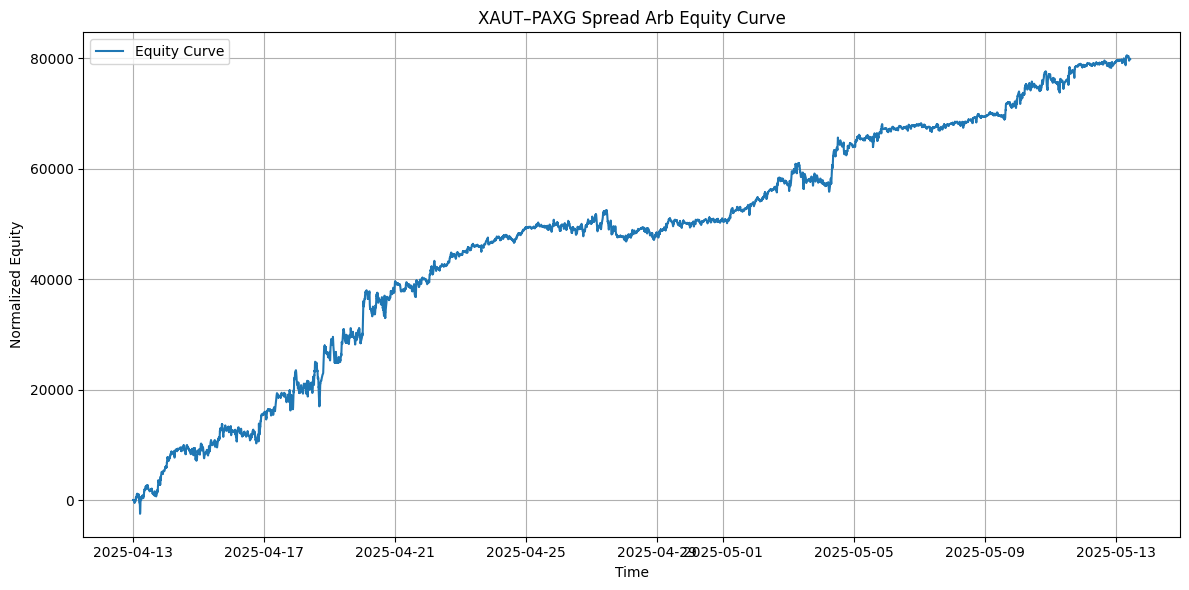

In [27]:
import matplotlib.pyplot as plt
total_return      = df['equity'].iloc[-1] - 1
minutes           = len(df)
annual_factor     = 252 * 24 * 60  # 年化依据
annual_return     = total_return * (annual_factor / minutes)
sharpe_ratio      = df['pnl'].mean() / df['pnl'].std() * np.sqrt(annual_factor)

print(f"总报酬:       {total_return:.2%}")
print(f"年化报酬:     {annual_return:.2%}")
print(f"年化 Sharpe:  {sharpe_ratio:.2f}")

# ----------------------------
# 7. 可视化
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df['equity'], label='Equity Curve')
plt.title('XAUT–PAXG Spread Arb Equity Curve')
plt.xlabel('Time')
plt.ylabel('Normalized Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()